# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

>By Soumia Zohra El Mestari.

---
### Why We're Here 

In this notebook, we will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project the  code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling. 

![Sample Dog Output](images/sample_dog_output.png)


### The Road Ahead

We break the notebook into separate steps

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


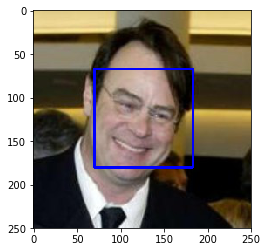

In [48]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [49]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

###  Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__  <br>
1- the face_detecor orrectly detected 98% of human faces from the 100 human images tested on them .<br> 
2- But he misclassified 17% of dogs images and detect human faces in them .<br> 
This 17% false positive rate is a bit high So this model can be considered as weak at this stage .

In [3]:
# this function test the performance of a dector passed in parameter 
def test_detector(function , human_files_path,dog_file_path):
    '''
    take a predictor and two paths files and test the accuracy over 100 images 
    
    Args:
        function : the predictor function
        human_files_path: path to human faces images
        dog_file_path : path to dogs images
        
    Returns:
        a tuple (true positive rate,true negative rate )
    '''
    human_count = 0
    dogs_count = 0
    
    for img in human_files_path: 
        if function(img):
            human_count += 1

    for img in dog_file_path:
        if function(img):
            dogs_count += 1
    
    return((human_count/len(human_files_path))*100,(dogs_count/(len(dog_file_path)))*100)

In [6]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

human_count , dogs_count = test_detector(face_detector , human_files_short,dog_files_short)
        

print('The percentage of detected human faces in the first 100 humans images is {}'.format(human_count))
print('The percentage of detected human faces in the first 100 dogs images is {}'.format(dogs_count))

The percentage of detected human faces in the first 100 humans images is 98.0
The percentage of detected human faces in the first 100 dogs images is 17.0


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [34]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    
print(VGG16)# print the neural network 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

###  Making Predictions with a Pre-trained Model

In the next code cell,  we will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

In [46]:
from PIL import Image
import torchvision.transforms as transforms


def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## Load and pre-process an image from the given img_path
    image = Image.open(img_path)
    
    ## Return the *index* of the predicted class for that image
    # pre trained models expect images to be normalised the same way as ImageNet 
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) 
    
    trans = transforms.Compose([
       transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.RandomHorizontalFlip(),
       transforms.ToTensor(),
       normalize
    ])
 
    img_processed =  trans(image)
     #PyTorch pretrained models expect the Tensor dims to be:
    #(num input imgs, num color channels, height, width).
    # while we have (num color channels, height, width);this will be fixed by inserting a new axis.
    # at index using unsqueeze_() function
    img_processed.unsqueeze_(0)
    
    # if Cuda available then move the image to Cuda 
    if use_cuda: 
        img_processed = img_processed.cuda()
    
    result = VGG16(img_processed)
    
    if use_cuda:
        result = result.cpu()
        
    result = result.data.numpy().argmax() # get the index of the predicted class
    
    return result

###  Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).


In [36]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    result =  VGG16_predict(img_path) # this result corresponds to the class index 
    return (result in range(151,269))# 269 because range method doesn't include the second parameter 

### Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [ ]:

human_count , dogs_count = test_detector(dog_detector , human_files_short,dog_files_short)
 
print('Test the Dog detector ')

print('The percentage of detected dogs in the first 100 humans images is {}'.format(human_count))
print('The percentage of detected dogs in the first 100 dogs images is {}'.format(dogs_count))


> *Result*: <br>
1-  percentage of the images in human_files_short have a detected dog is 1% <br> 
2-  percentage of the images in dog_files_short have a detected dog is 100% <br> 
=> Conclusion : 100% of true positives and 2 % of false postives ==> This classifier scored a good accuracy in this Dog's classification task 

We suggest VGG-16 as a potential network to detect dog images in your algorithm.

In [16]:
# Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.
# I will test vgg 19 on this dataset 
# define VGG19 model
vgg19 = models.vgg19(pretrained=True)

# move model to GPU if CUDA is available
if use_cuda:
    vgg19 = ResNet50.cuda()
    
print(vgg19)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [00:07<00:00, 74738473.28it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [17]:
def vgg19_predict(img_path):
    '''
    Use pre-trained ResNet-50 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to ResNet-50 model's prediction
    '''
    ## Load and pre-process an image from the given img_path
    image = Image.open(img_path)
    
    ## Return the *index* of the predicted class for that image
    # pre trained models expect images to be normalised the same way as ImageNet 
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) 
    
    trans = transforms.Compose([
       transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.RandomHorizontalFlip(),
       transforms.ToTensor(),
       normalize
    ])
 
    img_processed =  trans(image)
     #PyTorch pretrained models expect the Tensor dims to be:
    #(num input imgs, num color channels, height, width).
    # while we have (num color channels, height, width);this will be fixed by inserting a new axis.
    # at index using unsqueeze_() function
    img_processed.unsqueeze_(0)
    
    # if Cuda available then move the image to Cuda 
    if use_cuda: 
        img_processed = img_processed.cuda()
    
    result = vgg19(img_processed)
    
    if use_cuda:
        output = output.cpu()
        
    result = result.data.numpy().argmax() # get the index of the predicted class
    
    return result

In [20]:
def dog_detector_vgg19(img_path):
    result =  vgg19_predict(img_path) # this result corresponds to the class index 
    return (result in range(151,269))# 269 because range method doesn't include the second parameter 

In [21]:
human_count , dogs_count = test_detector(dog_detector_vgg19 , human_files_short,dog_files_short)
 
print('Test the Dog detector ')

print('The percentage of detected dogs in the first 100 humans images is {}'.format(human_count))
print('The percentage of detected dogs in the first 100 dogs images is {}'.format(dogs_count))


Test the Dog detector 
The percentage of detected dogs in the first 100 humans images is 1.0
The percentage of detected dogs in the first 100 dogs images is 99.0


>**Result**: <br> 
With Vgg-19 pretrained model we get 99% of true positives and 1% of false positives => So it seems like VGG16 scored better than VGG19 

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### Specify Data Loaders for the Dog Dataset

We Used the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [7]:
import os
from torchvision import datasets

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES=True


## Specify appropriate transforms, and batch_sizes
batch_size = 20
# I will keep the same normalization that I used for images to test on pretrained models 
normalization = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]) 
train_transfotms = transforms.Compose([
       transforms.RandomResizedCrop(224),
       transforms.RandomHorizontalFlip(), 
       transforms.RandomRotation(10),
       transforms.ToTensor(),
       normalization
    ])
# no need to perform any rotation or tranforms on validation and test sets 
valid_test_transforms = transforms.Compose([
       transforms.Resize((224,224)),
       transforms.ToTensor(),
       normalization
    ])

# define dataLoaders 

nbr_workers = 0 
train_data = datasets.ImageFolder('/data/dog_images/train', transform = train_transfotms )
valid_data = datasets.ImageFolder('/data/dog_images/valid', transform = valid_test_transforms)
test_data = datasets.ImageFolder('/data/dog_images/test', transform = valid_test_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True,
                                          num_workers=nbr_workers) 
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size,shuffle=True,
                                          num_workers=nbr_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True,
                                          num_workers=nbr_workers)

loaders = {'train': train_loader, 
           'valid': valid_loader, 
            'test': test_loader
          }



**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: <br> 
1- For the training set : I randomly crop and resize images to 224 by 224 pixels , knowing that each pixel have 3 channels ( corresponding to blue /green / red colours ) I get a tensor of size  3 * 224 * 224 , this size is enough to ensure this task . <br> 
In addition to that , and to help the model generalize better I performed a random horizontal flip and a random rotation, normalised the images and  convert them into tensors .<br> 
2- For the validation and test sets : These sets won't be used by th model to learn so there is no need to perform any flip or rotation on them , So resizing them, normalising and converting to tensors is enough to do a validation and testing of the model's performance 

###  Model Architecture

Create a CNN to classify dog breed. 

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d( 3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)
        
        #Maxpooling layer 
        self.pool = nn.MaxPool2d(2, 2)
        
        # the fully connected layers 
        self.fc1 = nn.Linear( 256 * 5 * 5, 300)
        self.fc2 = nn.Linear(300, 133) 
    
    def forward(self, x):
        ## Define forward behavior
        # pass through the Convolutional layers 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        
        # flatten image input
        x = x.view(-1, 5 * 5 * 256)
        # pass through the first and second fully connected layers 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x


# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  <br>

__Answer:__<br>
**First step defininng the convolutional layers** : <br> 
by default the padding is zero ( I didn't change it , the formula to calculate the output of a convoltional layer is : <br> 
(W_in - F + 2P)/S + 1 , where : <br> 
W_in : width / height square of the previous layer <br> 
F : filter size <br>
p : padding , here it's 0  <br>
S : stride , here it's equal to 1 by default and I didn't change it <br>
So the formula becomes : w_in - F +1 

conv1 : is the first convolutional layer in my network it takes a tensor of  224 * 224 * 3 and convert it to 222 * 222 * 16 <br> 
maxpooling layer 1 : convert the output of the conv1 to a tensor of  111 * 111 * 16 <br> 

conv2 : takes the output of maxpooling layer 1  and convert it to 109 * 109 * 32 <br> 
maxpooling layer 2 : convert the output of the conv2 to a tensor of 54 * 54 * 32 <br> 

conv3 : takes the output of maxpooling layer 2  and convert it to 52 * 52 * 64 <br> 
maxpooling layer 3 : convert the output of the conv2 to a tensor of  26 * 26 * 64 <br>

conv4 : takes the output of maxpooling layer 3  and convert it to  24 * 24 * 128<br> 
maxpooling layer 4 : convert the output of the conv2 to a tensor of   12 * 12 * 128<br>

conv5 : takes the output of maxpooling layer 4  and convert it to 10 * 10 * 256<br> 
maxpooling layer 5 : convert the output of the conv2 to a tensor of   5 * 5 * 256<br>

**Second step** : <br> 
Flatten the image input<br> 
**Third step** <br>
Feed the flattened image to two fully connected layers ; because we have 133 classes the output of the last fully connected layer should be of size 133 . 


### Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [9]:
import torch.optim as optim


criterion_scratch = nn.CrossEntropyLoss()

learning_rate = 0.03
optimizer_scratch = optim.Adadelta(model_scratch.parameters(), lr = learning_rate)

### Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [15]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # clear the cumulated grad 
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # evaluating the loss 
            loss = criterion(output, target)
            # backward pass
            loss.backward()
            # update weights 
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            
            loss = criterion(output, target)
           
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ##  save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min,
                    valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


# train the model
model_scratch = train(30, loaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 0.000637 	Validation Loss: 0.004993
Validation loss decreased (inf --> 0.004993).  Saving model ...
Epoch: 2 	Training Loss: 0.000630 	Validation Loss: 0.004987
Validation loss decreased (0.004993 --> 0.004987).  Saving model ...
Epoch: 3 	Training Loss: 0.000628 	Validation Loss: 0.004960
Validation loss decreased (0.004987 --> 0.004960).  Saving model ...
Epoch: 4 	Training Loss: 0.000626 	Validation Loss: 0.004916
Validation loss decreased (0.004960 --> 0.004916).  Saving model ...
Epoch: 5 	Training Loss: 0.000623 	Validation Loss: 0.004929
Epoch: 6 	Training Loss: 0.000619 	Validation Loss: 0.004963
Epoch: 7 	Training Loss: 0.000611 	Validation Loss: 0.004910
Validation loss decreased (0.004916 --> 0.004910).  Saving model ...
Epoch: 8 	Training Loss: 0.000612 	Validation Loss: 0.004936
Epoch: 9 	Training Loss: 0.000605 	Validation Loss: 0.005018
Epoch: 10 	Training Loss: 0.000602 	Validation Loss: 0.004810
Validation loss decreased (0.004910 --> 0.004810)

### Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [16]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.698596


Test Accuracy: 18% (153/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

###  Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 


In [2]:
## Specify data loaders
# I chose to use the same dataLoaders from previous step 

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [21]:
import torchvision.models as models
import torch.nn as nn
from collections import OrderedDict 

## Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

# freeze models parameters 
for param in  model_transfer.parameters():
    param.require_grad = False

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048,1024, bias=True)),
                          ('relu1', nn.ReLU()),
                          ('dropout1', nn.Dropout(p=0.5)),
                          ('fc2',nn.Linear(1024, 133, bias=True)),
                          ('output', nn.LogSoftmax(dim=1))
                        ]))

model_transfer.fc = classifier

if use_cuda:
    model_transfer = model_transfer.cuda()
    
print(model_transfer)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ <br>
I refered to the research paper by Aydin Ayanzadeh published in December 2018 in which a comparaison between ResNet, DenseNet and GoogleNet models in Dog breed classification task performance , the paper stated that Fine-tuning and data
augmentation techniques led to a significant increase in the model's accuracy <br> 
Further details can be found in the paper : https://www.preprints.org/manuscript/201812.0232/v1n <br>
Since the original dataSet ImageNet which ResNet50 was trained on contains features that are similar to our Dog Breed dataSet , Plus we have a small dataSet here => the best approach will be to replace the final fully connected layer and freeze all the original layers then train only the last fully connected layer .


### Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [25]:
criterion_transfer =  nn.NLLLoss()
optimizer_transfer = optim.Adadelta(model_transfer.fc.parameters(), lr=0.009)
n_epochs = 10#20

###  Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [26]:
# train the model
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.000250 	Validation Loss: 0.001130
Validation loss decreased (inf --> 0.001130).  Saving model ...
Epoch: 2 	Training Loss: 0.000245 	Validation Loss: 0.001080
Validation loss decreased (0.001130 --> 0.001080).  Saving model ...
Epoch: 3 	Training Loss: 0.000239 	Validation Loss: 0.001045
Validation loss decreased (0.001080 --> 0.001045).  Saving model ...
Epoch: 4 	Training Loss: 0.000233 	Validation Loss: 0.001028
Validation loss decreased (0.001045 --> 0.001028).  Saving model ...
Epoch: 5 	Training Loss: 0.000232 	Validation Loss: 0.000981
Validation loss decreased (0.001028 --> 0.000981).  Saving model ...
Epoch: 6 	Training Loss: 0.000227 	Validation Loss: 0.000978
Validation loss decreased (0.000981 --> 0.000978).  Saving model ...
Epoch: 7 	Training Loss: 0.000223 	Validation Loss: 0.000940
Validation loss decreased (0.000978 --> 0.000940).  Saving model ...
Epoch: 8 	Training Loss: 0.000219 	Validation Loss: 0.000918
Validation loss decreased (0.00094

### Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [27]:
test(loaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.709637


Test Accuracy: 81% (683/836)


###  Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [28]:
# list of class names by index, i.e. a name can be accessed like class_names[0]
data_transfer = {'train': train_data,
                   'valid': valid_data, 
                   'test': test_data}

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

    transform = transforms.Compose([
       transforms.Resize((224,224)),
       transforms.ToTensor(),
       normalize
    ])

    img_tensor = transform(img)
    img_tensor.unsqueeze_(0)

    if use_cuda: 
        img_tensor = img_tensor.cuda()
        
    output = model_transfer(img_tensor)
    _, prediction = torch.max(output.data,1)
    breed = class_names[prediction-1]
    
    return breed
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


###  Write your Algorithm

In [71]:

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

def run_app(img_path):
    img= mpimg.imread(img_path)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    print("\n")
    ## handle cases for a human face, dog, and neither
    if dog_detector(img_path) == True:
        print("Dog detected and its breed is : ",predict_breed_transfer(img_path))
    elif face_detector(img_path): 
        print('It is a human!.You look like ',predict_breed_transfer(img_path))
    else:
        print( "neither dogs nor  humans are in the picture")
    #img = np.asarray(Image.open(img_path))
    #plt.imshow(img)


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

###  Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.


__Answer:__ <br> 
1- The model is perfoming in a good way but due to the lack of data , some classes are misrepresented so the model didn't train as well as it should on these categories , therefore and after several tests sometimes the breed of a dog from a misrepresented class change from an execution to another , it's rarely happenning ( out of 30 tests I only observed this 5 times ) So I think providing more data will help the model learn better .<br>
2- In this project we only tested some models and architectures , maybe other architectures can score better on this dataset 



It is a human!.You look like  Curly-coated retriever


It is a human!.You look like  Curly-coated retriever


It is a human!.You look like  American staffordshire terrier


Dog detected and its breed is :  Bulldog


Dog detected and its breed is :  Bulldog


Dog detected and its breed is :  Bulldog


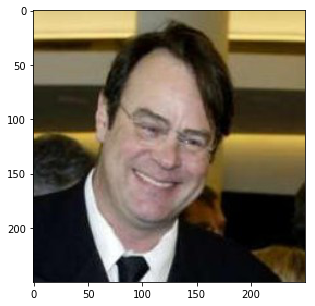

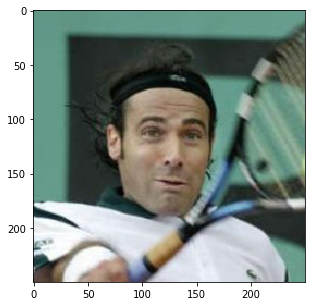

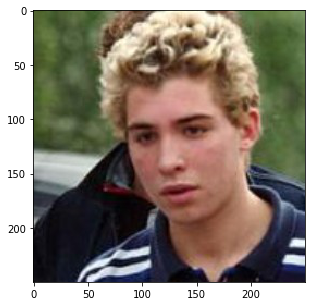

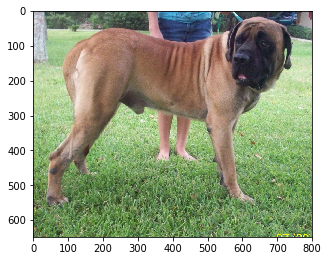

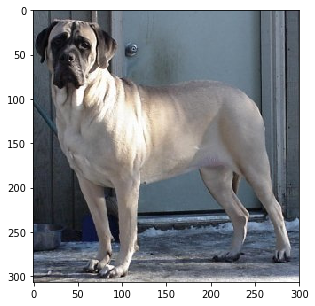

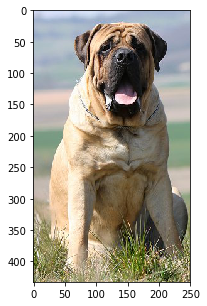

In [72]:
## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)
